Install Dependencies and Setup

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [19]:
import tensorflow as tf
import os

In [20]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [21]:
physical_devices = tf.config.list_physical_devices('GPU')
print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


Remove dodgy images

In [22]:
import cv2
import imghdr

In [23]:
#Source: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
data_dir = '/content/brain_tumor_dataset'
image_extensions = ['jpeg','jpg', 'bmp', 'png']

In [24]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list /content/brain_tumor_dataset/yes/Y46.jpg
Image not in ext list /content/brain_tumor_dataset/no/N3.jpg
Image not in ext list /content/brain_tumor_dataset/no/no 4.jpg


Load Data

In [25]:
import numpy as np
from matplotlib import pyplot as plt

In [28]:
data = tf.keras.utils.image_dataset_from_directory('/content/brain_tumor_dataset')

Found 250 files belonging to 2 classes.


In [29]:
data_iterator = data.as_numpy_iterator()

In [30]:
batch = data_iterator.next()

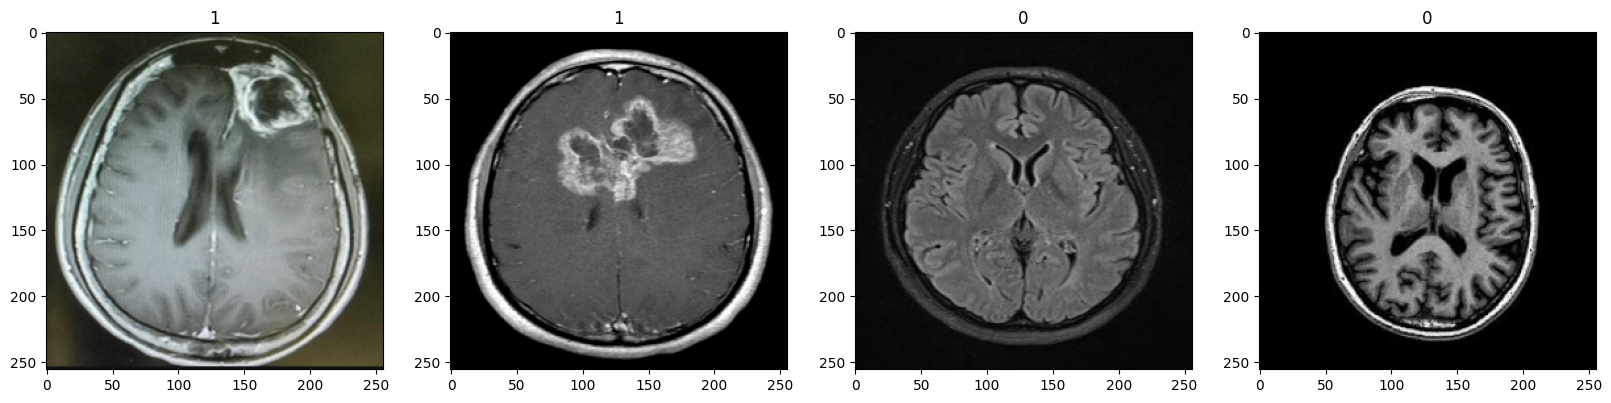

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Scale Data

In [32]:
data = data.map(lambda x,y: (x/255, y))

In [33]:
data.as_numpy_iterator().next()

(array([[[[0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314],
          ...,
          [0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314]],
 
         [[0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314],
          ...,
          [0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314]],
 
         [[0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314],
          ...,
          [0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314],
          [0.00784314, 0.00784314, 0.00784314]],
 
         ...,
 
         [[0.00784314, 0.00784314, 0.00784314],
          [0.00784

Split Data

In [34]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [35]:
train_size

5

In [36]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Build Deep Learning Model

In [37]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [39]:
model = Sequential()

In [40]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [41]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

Train

In [43]:
logdir='logs'

In [44]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [45]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
5/5 [==============================] - 8s 189ms/step - loss: 0.7461 - accuracy: 0.6187 - val_loss: 0.5447 - val_accuracy: 0.7812
Epoch 2/20
5/5 [==============================] - 1s 141ms/step - loss: 0.5446 - accuracy: 0.7375 - val_loss: 0.5592 - val_accuracy: 0.7500
Epoch 3/20
5/5 [==============================] - 1s 142ms/step - loss: 0.4639 - accuracy: 0.8250 - val_loss: 0.4021 - val_accuracy: 0.8438
Epoch 4/20
5/5 [==============================] - 1s 200ms/step - loss: 0.4382 - accuracy: 0.8125 - val_loss: 0.4586 - val_accuracy: 0.7812
Epoch 5/20
5/5 [==============================] - 1s 143ms/step - loss: 0.4385 - accuracy: 0.8125 - val_loss: 0.4096 - val_accuracy: 0.7812
Epoch 6/20
5/5 [==============================] - 1s 202ms/step - loss: 0.3928 - accuracy: 0.8438 - val_loss: 0.2969 - val_accuracy: 0.9688
Epoch 7/20
5/5 [==============================] - 1s 143ms/step - loss: 0.3057 - accuracy: 0.8938 - val_loss: 0.3225 - val_accuracy: 0.8750
Epoch 8/20
5/5 [====


Plot Performance



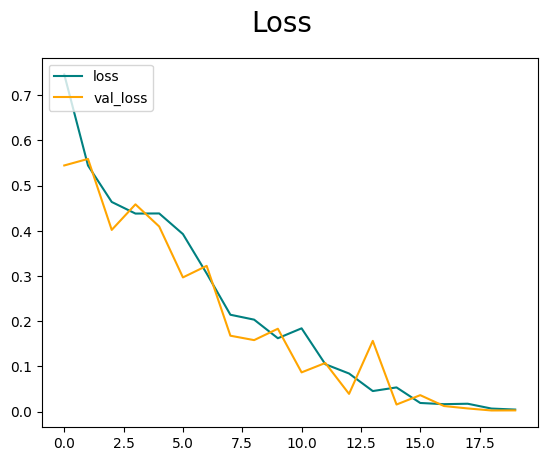

In [46]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

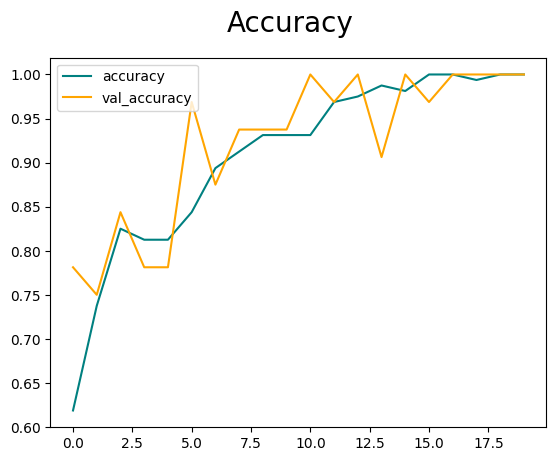

In [47]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate

In [48]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [49]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [50]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [51]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


Test

In [57]:
import cv2
import matplotlib.pyplot as plt

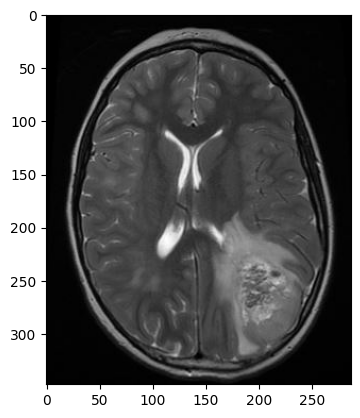

In [71]:
img = cv2.imread('/content/brain_tumor_dataset/yes/Y100.JPG')
plt.imshow(img)
plt.show()

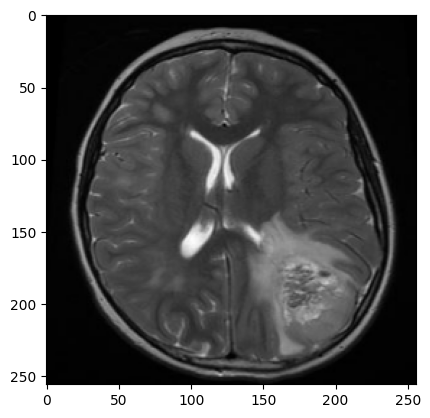

In [72]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [73]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 26ms/step


In [74]:
yhat

array([[0.9915079]], dtype=float32)

In [75]:
if yhat > 0.5:
    print(f'Predicted class is Cancer')
else:
    print(f'Predicted class is No Cancer')

Predicted class is Cancer


Save the Model

In [65]:
from tensorflow.keras.models import load_model

In [66]:
model.save(os.path.join('models','braincancerclassifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
new_model = load_model('/content/models/braincancerclassifier.h5')

In [70]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 82ms/step


array([[1.5949704e-06]], dtype=float32)